## Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import unidecode
import re
import string
import nltk
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from scipy.stats import ttest_rel


## Passo 1

Número total de mensagens: 5572
Número de spams: 747
Número de hams (não-spam): 4825


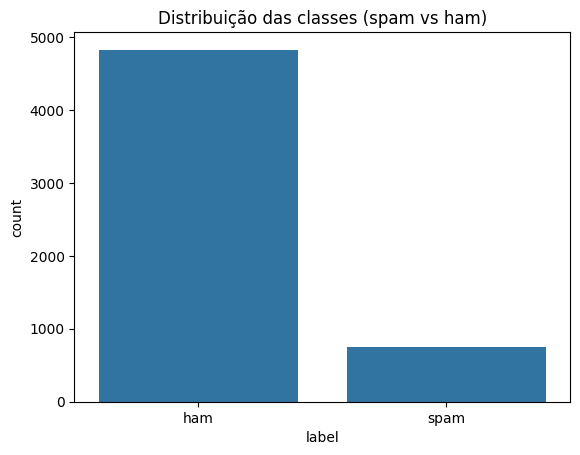

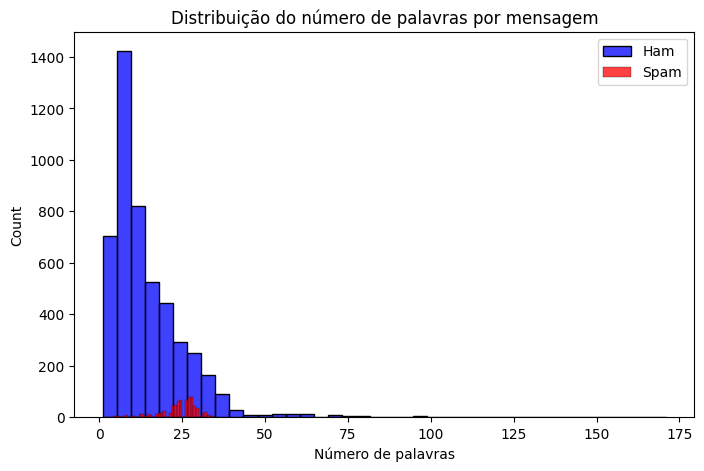


Estatísticas descritivas do número de palavras:
        count       mean        std  min   25%   50%   75%    max
label                                                            
ham    4825.0  14.310259  11.517945  1.0   7.0  11.0  19.0  171.0
spam    747.0  23.911647   5.780174  2.0  22.0  25.0  28.0   35.0


In [3]:

df = pd.read_csv("SMSSpamCollection", sep="\t", header=None, names=["label", "message"])

# Informações iniciais
print("Número total de mensagens:", len(df))
print("Número de spams:", sum(df["label"] == "spam"))
print("Número de hams (não-spam):", sum(df["label"] == "ham"))

# Distribuição das classes
sns.countplot(x="label", data=df)
plt.title("Distribuição das classes (spam vs ham)")
plt.show()

df["num_words"] = df["message"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
sns.histplot(df[df["label"]=="ham"]["num_words"], color="blue", bins=40, label="Ham", kde=False)
sns.histplot(df[df["label"]=="spam"]["num_words"], color="red", bins=40, label="Spam", kde=False)
plt.legend()
plt.title("Distribuição do número de palavras por mensagem")
plt.xlabel("Número de palavras")
plt.show()

print("\nEstatísticas descritivas do número de palavras:")
print(df.groupby("label")["num_words"].describe())


## Passo 2

In [4]:
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words
punctuations = string.punctuation 

nltk.download("names")
from nltk.corpus import names
english_names = set(names.words())

def preprocess_text(text):
    # Deixa tudo minúsculo
    text = text.lower()

    # Remove acentos
    text = unidecode.unidecode(text)

    # Tokenização e lematização
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    
    # Identificar as entidades para remover
    ents_to_remove = {ent.text.lower() for ent in doc.ents if ent.label_ in ["GPE", "ORG", "PERSON"]}

    # Remove stopwords, pontuações, hashtags, menções e pontuações
    tokens = [
        token.lemma_ for token in doc
        if token.lemma_ not in stopwords
        and token.is_alpha
        and not token.text.isnumeric() 
        and token.lemma_ not in punctuations
        and not token.text.startswith("#")
        and not token.text.startswith("@")
        and token.lemma_.lower() not in ents_to_remove
        and len(token.lemma_) >= 3
    ]

    
    # Reduzir repetições
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # Excluir URLs e links
    text = re.sub(r'http\S+|www\S+', '', text)

    # Juntar tokens de volta em string
    return " ".join(tokens)
display(df)


[nltk_data] Downloading package names to
[nltk_data]     C:\Users\thiag\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


,label,message,num_words
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30
5568,ham,Will ü b going to esplanade fr home?,8
5569,ham,"Pity, * was in mood for that. So...any other s...",10
5570,ham,The guy did some bitching but I acted like i'd...,26


In [5]:
df["message_clean"] = df["message"].apply(preprocess_text)

df[["message", "message_clean"]].head(30)

,message,message_clean
0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis great world...
1,Ok lar... Joking wif u oni...,lar joke wif oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win cup final tkts text r...
3,U dun say so early hor... U c already then say...,dun early hor
4,"Nah I don't think he goes to usf, he lives aro...",nah think usf live
5,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey darle week word like fun xxx std c...
6,Even my brother is not like to speak with me. ...,brother like speak treat like aids patent
7,As per your request 'Melle Melle (Oru Minnamin...,request melle melle oru minnaminunginte nurung...
8,WINNER!! As a valued network customer you have...,winner value network customer select receivea ...
9,Had your mobile 11 months or more? U R entitle...,mobile month entitle update late colour mobile...


## Passo 3

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(df["message_clean"])

# Labels (0 = ham, 1 = spam)
y = df["label"].map({"ham": 0, "spam": 1})

print("Formato da matriz TF-IDF:", X.shape)
print(X)


Formato da matriz TF-IDF: (5572, 5654)
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 32893 stored elements and shape (5572, 5654)>
  Coords	Values
  (0, 2578)	0.3761488445928049
  (0, 3666)	0.2697905478045791
  (0, 1089)	0.2860307740405683
  (0, 342)	0.2836238363210975
  (0, 668)	0.3177720639247395
  (0, 2058)	0.2074002606129956
  (0, 5538)	0.2544354459870648
  (0, 666)	0.3590747307909839
  (0, 885)	0.3177720639247395
  (0, 165)	0.3761488445928049
  (0, 5392)	0.2081729418512111
  (1, 2684)	0.4396020657733696
  (1, 2553)	0.494457003144156
  (1, 5471)	0.46469076328470776
  (1, 3391)	0.5884936620961707
  (2, 1848)	0.1735777145693475
  (2, 1551)	0.5411631506893206
  (2, 5508)	0.28644022195843544
  (2, 967)	0.29567997734144635
  (2, 5480)	0.19395336481838168
  (2, 1128)	0.3032294071856177
  (2, 1739)	0.27665201848251775
  (2, 5022)	0.33193070890407694
  (2, 4919)	0.17981025874005785
  (2, 3968)	0.24380653841112873
  :	:
  (5567, 3798)	0.2852150584662705
  (5567, 891)	0.27224

## Passo 4

In [7]:
# KNN feito na mão
class KNN:
    def __init__(self, k=5):
        self.k = k
    
    def fit(self, X_train, y_train):
        self.X_train = X_train.toarray()
        self.y_train = np.array(y_train)
    
    def predict(self, X_test):
        preds = []
        X_test = X_test.toarray()  
        for x in X_test:
            distancias = np.linalg.norm(self.X_train - x, axis=1)
            
            k_indices = distancias.argsort()[:self.k]

            k_vizinhos = self.y_train[k_indices]

            voto = Counter(k_vizinhos).most_common(1)[0][0]
            preds.append(voto)
        return np.array(preds)
    
    

In [8]:


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

modelos = {
    "KNN (manual)": KNN(k=5),  # KNN que eu fiz
    "KNN (sklearn)": KNeighborsClassifier(n_neighbors=5), # KNN usando sklearn
    "SVM": SVC(kernel="linear"),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

print("=== Resultados com hiperparâmetros fixos ===")
for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    print(f"\n📌 {nome}")
    print(f"Acurácia: {acc:.4f}")
    print(f"Macro F1: {f1:.4f}")


=== Resultados com hiperparâmetros fixos ===

📌 KNN (manual)
Acurácia: 0.9283
Macro F1: 0.7966

📌 KNN (sklearn)
Acurácia: 0.9274
Macro F1: 0.7932

📌 SVM
Acurácia: 0.9749
Macro F1: 0.9432

📌 Decision Tree
Acurácia: 0.9596
Macro F1: 0.9141


## Passo 5

In [ ]:
param_grids = {
    "KNN (sklearn)": {
        "n_neighbors": [3, 5, 7, 11, 15],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf"],
        "gamma": ["scale", "auto"]
    },
    "Decision Tree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10]
    }
}

print("\n=== Resultados com o GridSearch ===")
for nome, modelo in modelos.items():
    if nome not in param_grids:  # ignora o KNN manual
        continue
    
    grid = GridSearchCV(
        modelo,
        param_grids[nome],
        cv=5,
        scoring="f1_macro",
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    print(f"\n🔎 {nome}")
    print(f"Melhores parâmetros: {grid.best_params_}")
    print(f"Acurácia: {acc:.4f}")
    print(f"Macro F1: {f1:.4f}")



=== Resultados com o GridSearch ===

🔎 KNN (sklearn)
Melhores parâmetros: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Acurácia: 0.9534
Macro F1: 0.8812

🔎 SVM
Melhores parâmetros: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Acurácia: 0.9749
Macro F1: 0.9432

🔎 Decision Tree
Melhores parâmetros: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}
Acurácia: 0.9623
Macro F1: 0.9182


## Passo 6

In [ ]:
#Validação cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

modelos = {
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "SVM": SVC(kernel="linear"),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

resultados = {}
for nome, modelo in modelos.items():
    acc_scores = cross_val_score(modelo, X, y, cv=cv, scoring="accuracy")
    f1_scores = cross_val_score(modelo, X, y, cv=cv, scoring=make_scorer(f1_score, average="macro"))
    
    resultados[nome] = {
        "Acurácia média": np.mean(acc_scores),
        "Acurácia desvio": np.std(acc_scores),
        "F1 médio": np.mean(f1_scores),
        "F1 desvio": np.std(f1_scores)
    }

for nome, metrics in resultados.items():
    print(f"\n📌 {nome}")
    print(f"Acurácia: {metrics['Acurácia média']:.4f} ± {metrics['Acurácia desvio']:.4f}")
    print(f"Macro F1: {metrics['F1 médio']:.4f} ± {metrics['F1 desvio']:.4f}")



📌 KNN
Acurácia: 0.9095 ± 0.0042
Macro F1: 0.7212 ± 0.0187

📌 SVM
Acurácia: 0.9761 ± 0.0059
Macro F1: 0.9459 ± 0.0136

📌 Decision Tree
Acurácia: 0.9646 ± 0.0061
Macro F1: 0.9233 ± 0.0139


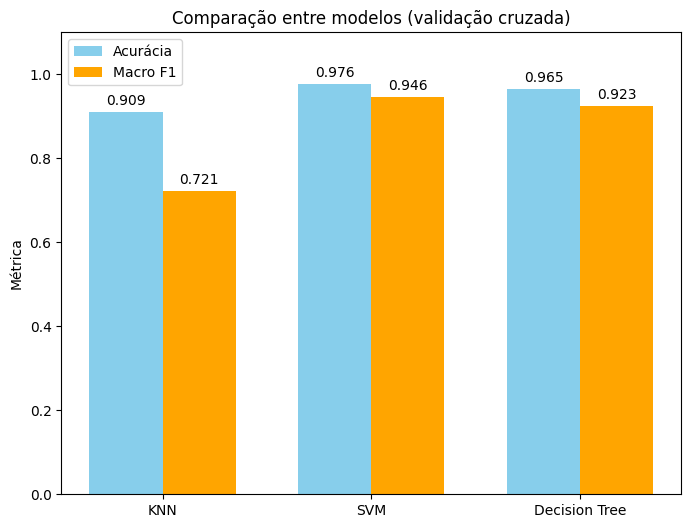

In [ ]:
#Graficos para comparação
models = ["KNN", "SVM", "Decision Tree"]

accuracies = [0.9095, 0.9761, 0.9646]
f1_scores  = [0.7212, 0.9459, 0.9233]

x = np.arange(len(models)) 
width = 0.35  

fig, ax = plt.subplots(figsize=(8,6))

acc_bars = ax.bar(x - width/2, accuracies, width, label='Acurácia', color='skyblue')
f1_bars  = ax.bar(x + width/2, f1_scores, width, label='Macro F1', color='orange')

ax.set_ylabel("Métrica")
ax.set_title("Comparação entre modelos (validação cruzada)")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

for bars in [acc_bars, f1_bars]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.ylim(0, 1.1)
plt.show()


In [15]:
#Teste Estatistico
alpha = 0.05
comparacoes = list(itertools.combinations(modelos.keys(), 2))
num_tests = len(comparacoes)
alpha_corrigido = alpha / num_tests  

print(f"Alpha corrigido (Bonferroni): {alpha_corrigido:.4f}\n")

f1_scores_modelos = {nome: cross_val_score(modelo, X, y, cv=cv, scoring=make_scorer(f1_score, average="macro"))
                     for nome, modelo in modelos.items()}

for (m1, m2) in comparacoes:
    stat, p = ttest_rel(f1_scores_modelos[m1], f1_scores_modelos[m2])
    print(f"{m1} vs {m2} -> p-valor = {p:.6f}")
    if p < alpha_corrigido:
        print("❌ Diferença estatisticamente significativa\n")
    else:
        print("✅ Não há diferença estatisticamente significativa\n")


Alpha corrigido (Bonferroni): 0.0167

KNN vs SVM -> p-valor = 0.000000
❌ Diferença estatisticamente significativa

KNN vs Decision Tree -> p-valor = 0.000000
❌ Diferença estatisticamente significativa

SVM vs Decision Tree -> p-valor = 0.000595
❌ Diferença estatisticamente significativa

